# Part 0: Preprocessing

In [1]:
# Import modules
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import random

In [2]:
# ignore deprecation warnings in sklearn

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Specify data directory

data_dir = os.path.join(os.path.dirname(os.getcwd()),'Data')

# Set model directory

model_dir = os.path.join(os.path.dirname(os.getcwd()), 'Model')

In [4]:
# Set data paths

train_path = os.path.join(data_dir, 'train.csv')

train_processed_path = os.path.join(data_dir, 'interim', 'train_preprocessed.txt')

meta_feat_path = os.path.join(data_dir, 'interim', 'meta_feat.txt')

In [35]:
train = pd.read_csv(train_path)
train_processed = pd.read_json(train_processed_path)
meta_feat = pd.read_json(meta_feat_path)

In [36]:
meta_feat.head()

,sentiment,n_upper,word_count,char_count,avg_wlen,adj_drug_count,n_stop,n_num,drug_category
0,2,1,76,404,5.315789,0.026316,28,0,38
1,2,5,206,1184,5.747573,0.000000,85,0,38
10,1,14,328,1807,5.509146,0.006098,133,4,55
100,1,9,146,703,4.815068,0.006849,62,6,89
1000,2,4,67,386,5.761194,0.029851,31,0,35


# Part 1: Machine Learning

In [50]:
# Import Naive Bayes

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from custom_function.ml import create_classifier, evaluate_classifier, get_model_results
import pickle

# Baseline Model

# Define X and y

X = meta_feat.drop("sentiment", axis = 1)
y = meta_feat.sentiment
indices = train_processed.index

# Split train and test set

Xtrain, Xtest, ytrain, ytest, itrain, itest = train_test_split(X, y, indices, train_size = 0.8, random_state = 42)

%%time

filename = 'baseline_lr.sav'

parameter = {'model__C':[0.01, 0.1, 1, 10, 100]}

clf = create_classifier(Xtrain,
                        ytrain,
                        LogisticRegression(solver = 'lbfgs', class_weight = 'balanced'),
                        parameter,
                        5,
                        'f1_macro',
                        open(os.path.join(model_dir,filename), 'wb'),
                        preprocess = StandardScaler())

# Extract classifier score
f1macro_score, cm = evaluate_classifier(clf,
                                       Xtest,
                                       ytest)

# Print score
print(f1macro_score)
print(cm)
print(clf.best_params_)

unique, counts = np.unique(clf.predict(Xtest), return_counts=True)
dict(zip(unique, counts))

# Bag of word models

In [53]:
# Define X and y

X = train_processed.text
y = train_processed.sentiment
indices = train_processed.index

# Split train and test set

Xtrain, Xtest, ytrain, ytest, itrain, itest = train_test_split(X, y, indices, train_size = 0.8, random_state = 42)

## Naive Bayes - BoW

%%time

filename = 'nb_bow.sav'

parameter = {'pre__min_df':[0.01, 0.1, 1, 10],
             'pre__ngram_range':[(1,1),(1,2)],
             'model__alpha':[0.01, 0.1, 1, 10]}

clf = create_classifier(Xtrain,
                        ytrain,
                        MultinomialNB(),
                        parameter,
                        5,
                        'f1_macro',
                        open(os.path.join(model_dir,filename), 'wb'),
                        preprocess = CountVectorizer())

# Extract classifier score
f1macro_score, cm = evaluate_classifier(clf,
                                       Xtest,
                                       ytest)

# Print score
print(f1macro_score)
print(cm)
print(clf.best_params_)

## Naive Bayes - Tfidf

%%time

filename = 'nb_tfidf.sav'

parameter = {'pre__min_df':[0.01, 0.1, 1, 10],
             'pre__ngram_range':[(1,1),(1,2)],
             'model__alpha':[0.01, 0.1, 1, 10]}

clf = create_classifier(Xtrain,
                        ytrain,
                        MultinomialNB(),
                        parameter,
                        5,
                        'f1_macro',
                        open(os.path.join(model_dir,filename), 'wb'),
                        preprocess = TfidfVectorizer())

# Extract classifier score
f1macro_score, cm = evaluate_classifier(clf,
                                       Xtest,
                                       ytest)

# Print score
print(f1macro_score)
print(cm)
print(clf.best_params_)

## Random Forest - BoW

%%time

filename = 'rf_bow.sav'

parameter = {'pre__min_df':[0.01, 0.1, 1, 10],
              'pre__ngram_range':[(1,1),(1,2)],
              'model__n_estimators':[10 , 20, 40],
              'model__max_features': ['auto', 'sqrt', 'log2']}

clf = create_classifier(Xtrain,
                        ytrain,
                        RandomForestClassifier(),
                        parameter,
                        5,
                        'f1_macro',
                        open(os.path.join(model_dir,filename), 'wb'),
                        preprocess = CountVectorizer())

# Extract classifier score
f1macro_score, cm = evaluate_classifier(clf,
                                       Xtest,
                                       ytest)

# Print score
print(f1macro_score)
print(cm)
print(clf.best_params_)

## Random Forest - Tfidf

%%time

filename = 'rf_tfidf.sav'

parameter = {'pre__min_df':[0.01, 0.1, 1, 10],
              'pre__ngram_range':[(1,1),(1,2)],
              'model__n_estimators':[10 , 20, 40],
              'model__max_features': ['auto', 'sqrt', 'log2']}

clf = create_classifier(Xtrain,
                        ytrain,
                        RandomForestClassifier(),
                        parameter,
                        5,
                        'f1_macro',
                        open(os.path.join(model_dir,filename), 'wb'),
                        preprocess = TfidfVectorizer())

# Extract classifier score
f1macro_score, cm = evaluate_classifier(clf,
                                       Xtest,
                                       ytest)

# Print score
print(f1macro_score)
print(cm)
print(clf.best_params_)

## SVC - BoW

%%time

filename = 'svc_bow.sav'

parameter = {'pre__min_df':[0.01, 0.1, 1, 10],
             'pre__ngram_range':[(1,1),(1,2)],
              'model__C':[0.01, 0.1, 1],
              'model__kernel':['linear', 'poly', 'rbf'],
              'model__gamma':['auto', 'scale']}

clf = create_classifier(Xtrain,
                        ytrain,
                        SVC(),
                        parameter,
                        3,
                        'f1_macro',
                        open(os.path.join(model_dir,filename), 'wb'),
                        preprocess = CountVectorizer())

# Extract classifier score
f1macro_score, cm = evaluate_classifier(clf,
                                       Xtest,
                                       ytest)

# Print score
print(f1macro_score)
print(cm)
print(clf.best_params_)

## SVC - Tfidf

%%time

filename = 'svc_tfidf.sav'

parameter = {'pre__min_df':[0.01, 0.1, 1, 10],
             'pre__ngram_range':[(1,1),(1,2)],
              'model__C':[0.01, 0.1, 1],
              'model__kernel':['linear', 'poly', 'rbf'],
              'model__gamma':['auto', 'scale']}

clf = create_classifier(Xtrain,
                        ytrain,
                        SVC(),
                        parameter,
                        3,
                        'f1_macro',
                        open(os.path.join(model_dir,filename), 'wb'),
                        preprocess = TfidfVectorizer())

# Extract classifier score
f1macro_score, cm = evaluate_classifier(clf,
                                       Xtest,
                                       ytest)

# Print score
print(f1macro_score)
print(cm)
print(clf.best_params_)

## Logistic Regression - Bow

%%time

filename = 'lr_bow.sav'

parameter = {'pre__min_df':[0.01, 0.1, 1, 10],
             'pre__ngram_range':[(1,1),(1,2)],
             'model__C':[0.01, 0.1, 1, 10, 100]}

clf = create_classifier(Xtrain,
                        ytrain,
                        LogisticRegression(solver = 'lbfgs', class_weight = 'balanced'),
                        parameter,
                        5,
                        'f1_macro',
                        open(os.path.join(model_dir,filename), 'wb'),
                        preprocess = CountVectorizer())

# Extract classifier score
f1macro_score, cm = evaluate_classifier(clf,
                                       Xtest,
                                       ytest)

# Print score
print(f1macro_score)
print(cm)
print(clf.best_params_)

## Logistic Regression - Tfidf

%%time

filename = 'lr_tfidf.sav'

parameter = {'pre__min_df':[0.01, 0.1, 1, 10],
             'pre__ngram_range':[(1,1),(1,2)],
             'model__C':[0.01, 0.1, 1, 10, 100]}

clf = create_classifier(Xtrain,
                        ytrain,
                        LogisticRegression(solver = 'lbfgs', class_weight = 'balanced'),
                        parameter,
                        5,
                        'f1_macro',
                        open(os.path.join(model_dir,filename), 'wb'),
                        preprocess = TfidfVectorizer())

# Extract classifier score
f1macro_score, cm = evaluate_classifier(clf,
                                       Xtest,
                                       ytest)

# Print score
print(f1macro_score)
print(cm)
print(clf.best_params_)

## SGD - Bow

%%time

filename = 'sgd_bow.sav'

parameter = {'pre__min_df':[0.01, 0.1, 1, 10],
             'pre__ngram_range':[(1,1),(1,2)],
             'model__alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2]}

clf = create_classifier(Xtrain,
                        ytrain,
                        SGDClassifier(max_iter = 1000, loss = 'log', penalty = 'l2'),
                        parameter,
                        5,
                        'f1_macro',
                        open(os.path.join(model_dir,filename), 'wb'),
                        preprocess = CountVectorizer())

# Extract classifier score
f1macro_score, cm = evaluate_classifier(clf,
                                       Xtest,
                                       ytest)

# Print score
print(f1macro_score)
print(cm)
print(clf.best_params_)

## SGD - Tfidf

%%time

filename = 'sgd_tfidf.sav'

parameter = {'pre__min_df':[0.01, 0.1, 1, 10],
             'pre__ngram_range':[(1,1),(1,2)],
             'model__alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2]}

clf = create_classifier(Xtrain,
                        ytrain,
                        SGDClassifier(max_iter = 1000, loss = 'log', penalty = 'l2'),
                        parameter,
                        5,
                        'f1_macro',
                        open(os.path.join(model_dir,filename), 'wb'),
                        preprocess = TfidfVectorizer())

# Extract classifier score
f1macro_score, cm = evaluate_classifier(clf,
                                       Xtest,
                                       ytest)

# Print score
print(f1macro_score)
print(cm)
print(clf.best_params_)

In [58]:
models = ['nb_bow.sav', 'nb_tfidf.sav', 
          'rf_bow.sav', 'rf_tfidf.sav', 
          'svc_bow.sav', 'svc_tfidf.sav', 
          'lr_bow.sav', 'lr_tfidf.sav',
          'sgd_bow.sav', 'sgd_tfidf.sav']

results = get_model_results(models, model_dir, Xtest, ytest)
results

,model,f1_macro
0,nb_bow.sav,0.443089
1,nb_tfidf.sav,0.430053
2,rf_bow.sav,0.348805
3,rf_tfidf.sav,0.362117
4,svc_bow.sav,0.430939
5,svc_tfidf.sav,0.342595
6,lr_bow.sav,0.488090
7,lr_tfidf.sav,0.500102
8,sgd_bow.sav,0.418400
9,sgd_tfidf.sav,0.365344


# Stacked Model

## Stacking Meta and BoW Features

In [79]:
# Vectorizing the sparse features

vec = TfidfVectorizer(min_df = 15, ngram_range=(1, 2))
#vec_fit = vec.fit(train_processed.text)
sparse_feat = vec.fit_transform(train_processed.text)
sparse_feat

# Scaling meta features

scaler = MinMaxScaler()
meta_feat_scaled = scaler.fit_transform(meta_feat.drop("sentiment", axis = 1))

# Combine the features

from scipy.sparse import coo_matrix, hstack

meta_feat_scaled = coo_matrix(meta_feat_scaled)
meta_feat_scaled

# Derive X and Y

X = hstack([sparse_feat, meta_feat_scaled.astype(float)])
y = train_processed.sentiment
indices = train_processed.index

# Derive train/test set

from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest, itrain, itest = train_test_split(X, y, indices, train_size = 0.8, random_state = 42)

filename = 'lr_stacked.sav'


parameter = {'model__C':[0.01, 0.1, 1, 10, 100, 1000]}

clf = create_classifier(Xtrain,
                        ytrain,
                        LogisticRegression(solver = 'lbfgs', class_weight = 'balanced'),
                        parameter,
                        5,
                        'f1_macro',
                        open(os.path.join(model_dir,filename), 'wb'))

# Extract classifier score
f1macro_score, cm = evaluate_classifier(clf,
                                       Xtest,
                                       ytest)

# Print score
print(f1macro_score)
print(cm)
print(clf.best_params_)

### Logistic Regression

### Naive Bayes

filename = 'nb_stacked.sav'

parameter = {'model__alpha':[0.01, 0.1, 1, 10, 100]}

clf = create_classifier(Xtrain,
                        ytrain,
                        MultinomialNB(),
                        parameter,
                        5,
                        'f1_macro',
                        open(os.path.join(model_dir,filename), 'wb'))

# Extract classifier score
f1macro_score, cm = evaluate_classifier(clf,
                                       Xtest,
                                       ytest)

# Print score
print(f1macro_score)
print(cm)
print(clf.best_params_)

### SVC

filename = 'svc_stacked.sav'

parameter = {'model__C':[0.01, 0.1, 1],
             'model__kernel':['linear', 'poly', 'rbf'],
             'model__gamma':['auto', 'scale']}


clf = create_classifier(Xtrain,
                        ytrain,
                        SVC(),
                        parameter,
                        3,
                        'f1_macro',
                        open(os.path.join(model_dir,filename), 'wb'))

# Extract classifier score
f1macro_score, cm = evaluate_classifier(clf,
                                       Xtest,
                                       ytest)

# Print score
print(f1macro_score)
print(cm)
print(clf.best_params_)

### SGD

filename = 'sgd_stacked.sav'

parameter = {'model__alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2]}


clf = create_classifier(Xtrain,
                        ytrain,
                        SGDClassifier(),
                        parameter,
                        3,
                        'f1_macro',
                        open(os.path.join(model_dir,filename), 'wb'))

# Extract classifier score
f1macro_score, cm = evaluate_classifier(clf,
                                       Xtest,
                                       ytest)

# Print score
print(f1macro_score)
print(cm)
print(clf.best_params_)

In [84]:
models = ['nb_stacked.sav', 'lr_stacked.sav', 'svc_stacked.sav', 'sgd_stacked.sav']
results = get_model_results(models, model_dir, Xtest, ytest)
results

,model,f1_macro
0,nb_stacked.sav,0.430446
1,lr_stacked.sav,0.492030
2,svc_stacked.sav,0.361986
3,sgd_stacked.sav,0.417685


# Embedding models

## Word2vec custom trained

In [85]:
from gensim.models import Word2Vec, KeyedVectors
import multiprocessing


In [86]:
def get_mean_vector(word2vec_model, n_dim, doc):
    ### From a document, derive the mean vector of its vocabularies with embeddings from a specified word2vec model with dimension n
    ###
    
    # remove out-of-vocabulary words
    word_list = [word for word in doc if word in word2vec_model.wv.vocab]
    
    # Take average if the doc contains in-vocabulary words, else, take a matrix of zeroes
    if len(word_list) >= 1:
        return np.mean(word2vec_model[word_list], axis=0)
    else:
        return ([0] * n_dim)

In [109]:
%%time
#### Create Word2vec word embeddings
n_dim = 400
w2v_window_grid = {}
for n_window in np.arange(1,20,2):

    sentences = [row.split() for row in train_processed.text]

    cores = multiprocessing.cpu_count()

    w2v_model = Word2Vec(min_count=10,
                         window=n_window,
                         size=n_dim,
                         sample=6e-5, 
                         alpha=0.03, 
                         min_alpha=0.0007, 
                         negative=20,
                         workers=cores-1)

    w2v_model.build_vocab(sentences)

    w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30)

    #### Derive word2vec features

    # Create a dictionary with the vocabs and its embeddings
    w2v = dict(zip(w2v_model.wv.index2word, w2v_model.wv.syn0))

    # Initialize a vector features dictionary
    vec_features = {}

    # Iterate over the documents to get the mean of word embeddings feature to derive document embeddings
    for index, doc in train_processed.text.iteritems(): 
        vec_features[index] = get_mean_vector(w2v_model, n_dim, doc.split(' '))

    # Create a document feature dataframe
    vec_features_df = pd.DataFrame.from_dict(vec_features, 'index')
    vec_features_df.shape

    #### Evaluate classifier with given word2vec embeddings

    # Define X and y

    X = vec_features_df
    y = train_processed.sentiment
    indices = train_processed.index

    # Split train and test set

    Xtrain, Xtest, ytrain, ytest, itrain, itest = train_test_split(X, y, indices, train_size = 0.8, random_state = 42)

    # Specify save file for model
    filename = 'lr_w2v.sav'

    # Specify parameter grid
    parameter = {'model__C':[0.01, 0.1, 1, 10, 100]}

    # Run grid search to create best classifier of type
    clf = create_classifier(Xtrain, 
                            ytrain,
                            LogisticRegression(solver = 'lbfgs', class_weight = 'balanced'),
                            parameter,
                            5,
                            'f1_macro',
                            open(os.path.join(model_dir,filename), 'wb'))

    # Extract classifier score
    f1macro_score, cm = evaluate_classifier(clf,
                                           Xtest,
                                           ytest)

    # Save score
    w2v_window_grid[n_window] = f1macro_score

    # Print score
    print("The word embedding dimension number is", n_dim)
    print(f1macro_score)
    print(cm)
    print(clf.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  13 out of  25 | elapsed:    6.4s remaining:    5.9s
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:    8.1s remaining:    4.5s
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:   11.5s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:   12.1s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   12.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   12.4s finished


The word embedding dimension number is 400
0.4488771034664754
[[ 46  32  36]
 [ 22  96  49]
 [151 188 436]]
{'model__C': 1}
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  13 out of  25 | elapsed:    6.7s remaining:    6.2s
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:    8.7s remaining:    4.9s
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:   11.9s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:   12.8s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   13.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   13.3s finished


The word embedding dimension number is 400
0.4595443279928815
[[ 46  31  37]
 [ 11 108  48]
 [155 193 427]]
{'model__C': 0.1}
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  13 out of  25 | elapsed:    7.0s remaining:    6.4s
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:    9.3s remaining:    5.2s
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:   12.2s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:   13.3s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   13.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   13.6s finished


The word embedding dimension number is 400
0.45522944415519834
[[ 45  32  37]
 [  9 109  49]
 [165 189 421]]
{'model__C': 0.1}
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  13 out of  25 | elapsed:    7.2s remaining:    6.7s
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:    9.8s remaining:    5.5s
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:   12.2s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:   13.6s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   13.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   13.9s finished


The word embedding dimension number is 400
0.4539968297969444
[[ 46  35  33]
 [ 13 106  48]
 [166 186 423]]
{'model__C': 0.1}
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  13 out of  25 | elapsed:    7.6s remaining:    7.0s
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:   10.0s remaining:    5.6s
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:   12.6s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:   13.8s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   14.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   14.3s finished


The word embedding dimension number is 400
0.46020170173545544
[[ 48  30  36]
 [ 12 108  47]
 [163 190 422]]
{'model__C': 0.1}
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  13 out of  25 | elapsed:    7.5s remaining:    6.9s
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:   10.5s remaining:    5.8s
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:   12.8s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:   14.1s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   14.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   14.5s finished


The word embedding dimension number is 400
0.45773190528803953
[[ 49  32  33]
 [ 16 104  47]
 [157 194 424]]
{'model__C': 0.1}
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  13 out of  25 | elapsed:    9.2s remaining:    8.5s
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:   12.1s remaining:    6.8s
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:   13.7s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:   15.1s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   15.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   15.7s finished


The word embedding dimension number is 400
0.46944708646400574
[[ 52  29  33]
 [ 15  98  54]
 [157 173 445]]
{'model__C': 0.1}
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  13 out of  25 | elapsed:    7.5s remaining:    6.9s
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:   10.4s remaining:    5.8s
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:   12.6s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:   14.0s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   14.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   14.3s finished


The word embedding dimension number is 400
0.4596076160851294
[[ 50  29  35]
 [ 19 100  48]
 [157 186 432]]
{'model__C': 0.1}
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  13 out of  25 | elapsed:    7.5s remaining:    6.9s
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:   10.7s remaining:    5.9s
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:   12.4s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:   13.9s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   14.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   14.3s finished


The word embedding dimension number is 400
0.4575154608043878
[[ 48  30  36]
 [ 16 101  50]
 [166 177 432]]
{'model__C': 0.1}
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  13 out of  25 | elapsed:    7.5s remaining:    6.9s
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:   10.6s remaining:    5.9s
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:   12.7s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:   14.0s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   14.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   14.5s finished


The word embedding dimension number is 400
0.46798292021071797
[[ 52  28  34]
 [ 18 102  47]
 [154 186 435]]
{'model__C': 0.1}
Wall time: 12min 23s


In [110]:
w2v_window_df = pd.DataFrame.from_dict(w2v_window_grid, orient = 'index' )

In [111]:
w2v_window_df.to_json(os.path.join(data_dir, 'interim', 'w2v_window_search_results.txt'))

In [112]:
w2v_window_df = pd.read_json(os.path.join(data_dir, 'interim', 'w2v_window_search_results.txt'))

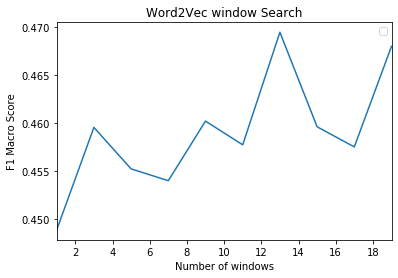

In [114]:
w2v_window_df.sort_index().plot()
plt.title('Word2Vec window Search')
plt.xlabel('Number of windows')
plt.ylabel('F1 Macro Score')
plt.legend('')
plt.show()

## Word2Vec Google Pre-Trained Model

In [ ]:
# Load Google's pre-trained Word2Vec model.

w2v_google_model = KeyedVectors.load_word2vec_format(os.path.join(model_dir, 'embeddings', 'GoogleNews-vectors-negative300.bin'), binary=True)

In [ ]:
# Create a dictionary with the vocabs and its embeddings
w2v = dict(zip(w2v_google_model.wv.index2word, w2v_google_model.wv.syn0))

# Initialize a vector features dictionary
vec_features = {}

# Iterate over the documents to get the mean of word embeddings feature to derive document embeddings
for index, doc in train_processed.text.iteritems(): 
    vec_features[index] = get_mean_vector(w2v_google_model, 300, doc.split(' '))

# Create a document feature dataframe
vec_features_df = pd.DataFrame.from_dict(vec_features, 'index')
vec_features_df.shape

#### Evaluate classifier with given word2vec embeddings

# Define X and y

X = vec_features_df
y = train_processed.sentiment
indices = train_processed.index

# Split train and test set

Xtrain, Xtest, ytrain, ytest, itrain, itest = train_test_split(X, y, indices, train_size = 0.8, random_state = 42)

# Specify save file for model
filename = 'lr_w2v_pretrained_google.sav'

# Specify parameter grid
parameter = {'model__C':[0.01, 0.1, 1, 10, 100]}

# Run grid search to create best classifier of type
clf = create_classifier(Xtrain, 
                        ytrain,
                        LogisticRegression(solver = 'lbfgs', class_weight = 'balanced'),
                        parameter,
                        5,
                        'f1_macro',
                        open(os.path.join(model_dir,filename), 'wb'))

# Extract classifier score
f1macro_score, cm = evaluate_classifier(clf,
                                       Xtest,
                                       ytest)

# Print score
print(f1macro_score)
print(cm)
print(clf.best_params_)

## GloVe Stanford Pre-trained

import spacy

nlp = spacy.load('en_vectors_web_lg')

total_vectors = len(nlp.vocab.vectors)
print('Total word vectors:', total_vectors)

from gensim.scripts.glove2word2vec import glove2word2vec
glove_input_file = os.path.join(model_dir, 'embeddings', 'glove.6B.300d.txt')
word2vec_output_file = os.path.join(model_dir, 'embeddings','glove.6B.300d.txt.word2vec')
glove2word2vec(glove_input_file, word2vec_output_file)

In [ ]:
from gensim.scripts.glove2word2vec import glove2word2vec
word2vec_output_file = os.path.join(model_dir, 'embeddings','glove.6B.300d.txt.word2vec')
w2v_glove_stanford_model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

In [ ]:
# Create a dictionary with the vocabs and its embeddings
w2v = dict(zip(w2v_glove_stanford_model.wv.index2word, w2v_glove_stanford_model.wv.syn0))

# Initialize a vector features dictionary
vec_features = {}

# Iterate over the documents to get the mean of word embeddings feature to derive document embeddings
for index, doc in train_processed.text.iteritems(): 
    vec_features[index] = get_mean_vector(w2v_glove_stanford_model, 300, doc.split(' '))

# Create a document feature dataframe
vec_features_df = pd.DataFrame.from_dict(vec_features, 'index')
vec_features_df.shape

#### Evaluate classifier with given word2vec embeddings

# Define X and y

X = vec_features_df
y = train_processed.sentiment
indices = train_processed.index

# Split train and test set

Xtrain, Xtest, ytrain, ytest, itrain, itest = train_test_split(X, y, indices, train_size = 0.8, random_state = 42)

# Specify save file for model
filename = 'lr_w2v_pretrained_glove_stanford.sav'

# Specify parameter grid
parameter = {'model__C':[0.01, 0.1, 1, 10, 100]}

# Run grid search to create best classifier of type
clf = create_classifier(Xtrain, 
                        ytrain,
                        LogisticRegression(solver = 'lbfgs', class_weight = 'balanced'),
                        parameter,
                        5,
                        'f1_macro',
                        open(os.path.join(model_dir,filename), 'wb'))

# Extract classifier score
f1macro_score, cm = evaluate_classifier(clf,
                                       Xtest,
                                       ytest)

# Print score
print(f1macro_score)
print(cm)
print(clf.best_params_)

## Fastext

In [ ]:
import nltk
from gensim.models.fasttext import FastText

wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(doc) for document in train_processed.text]

In [ ]:
# Set values for various parameters
feature_size = 300    # Word vector dimensionality  
window_context = 50          # Context window size                                                                                    
min_word_count = 5   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words


ft_model = FastText(tokenized_corpus, 
                    size=feature_size, 
                    window=window_context, 
                    min_count=min_word_count,
                    sample=sample, 
                    sg=1, 
                    iter=50)

In [ ]:
# Create a dictionary with the vocabs and its embeddings
w2v = dict(zip(ft_model.wv.index2word, ft_model.wv.syn0))

# Initialize a vector features dictionary
vec_features = {}

# Iterate over the documents to get the mean of word embeddings feature to derive document embeddings
for index, doc in train_processed.text.iteritems(): 
    vec_features[index] = get_mean_vector(ft_model, 300, doc.split(' '))

# Create a document feature dataframe
vec_features_df = pd.DataFrame.from_dict(vec_features, 'index')
vec_features_df.shape

#### Evaluate classifier with given word2vec embeddings

# Define X and y

X = vec_features_df
y = train_processed.sentiment
indices = train_processed.index

# Split train and test set

Xtrain, Xtest, ytrain, ytest, itrain, itest = train_test_split(X, y, indices, train_size = 0.8, random_state = 42)

# Specify save file for model
filename = 'lr_w2v_fasttext.sav'

# Specify parameter grid
parameter = {'model__C':[0.01, 0.1, 1, 10, 100]}

# Run grid search to create best classifier of type
clf = create_classifier(Xtrain, 
                        ytrain,
                        LogisticRegression(solver = 'lbfgs', class_weight = 'balanced'),
                        parameter,
                        5,
                        'f1_macro',
                        open(os.path.join(model_dir,filename), 'wb'))

# Extract classifier score
f1macro_score, cm = evaluate_classifier(clf,
                                       Xtest,
                                       ytest)

# Print score
print(f1macro_score)
print(cm)
print(clf.best_params_)

## Results

weights = pd.DataFrame(w2v).transpose()

similar_words = {search_term: [item[0] for item in w2v_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['patient', 'drug', 'therapy', 'treatment', 'vaccine', 'health', 'public','effective']}
similar_words

from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')